In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2


Bad key "hatch.linewidth" on line 54 in
/home/gpleiss/.dotfiles/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
from torch.autograd import Variable
train_x = Variable(torch.linspace(0, 1, 11))
train_y = Variable(torch.sin(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2)

In [3]:
from torch import optim
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [4]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(constant_bounds=(-1, 1))
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-5, 5))
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return GaussianRandomVariable(mean_x, covar_x)

likelihood = GaussianLikelihood(log_noise_bounds=(-5, 5))
model = ExactGPModel(train_x.data, train_y.data, likelihood)

In [5]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

optimizer = optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)
optimizer.n_iter = 0
for i in range(50):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -model.marginal_log_likelihood(likelihood, output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/20 - Loss: %.3f   log_lengthscale: %.3f   log_noise: %.3f' % (
        i + 1, loss.data[0],
        model.covar_module.log_lengthscale.data[0, 0],
        model.likelihood.log_noise.data[0]
    ))
    optimizer.step()

Iter 1/20 - Loss: 1.239   log_lengthscale: 0.000   log_noise: 0.000
Iter 2/20 - Loss: 1.101   log_lengthscale: -0.100   log_noise: -0.200
Iter 3/20 - Loss: 1.074   log_lengthscale: -0.200   log_noise: -0.400
Iter 4/20 - Loss: 1.130   log_lengthscale: -0.259   log_noise: -0.596
Iter 5/20 - Loss: 0.994   log_lengthscale: -0.333   log_noise: -0.788
Iter 6/20 - Loss: 0.951   log_lengthscale: -0.415   log_noise: -0.974
Iter 7/20 - Loss: 0.972   log_lengthscale: -0.503   log_noise: -1.156
Iter 8/20 - Loss: 0.818   log_lengthscale: -0.591   log_noise: -1.328
Iter 9/20 - Loss: 0.964   log_lengthscale: -0.678   log_noise: -1.486
Iter 10/20 - Loss: 0.922   log_lengthscale: -0.765   log_noise: -1.633
Iter 11/20 - Loss: 0.849   log_lengthscale: -0.855   log_noise: -1.766
Iter 12/20 - Loss: 0.708   log_lengthscale: -0.946   log_noise: -1.883
Iter 13/20 - Loss: 0.586   log_lengthscale: -1.040   log_noise: -1.991
Iter 14/20 - Loss: 0.852   log_lengthscale: -1.137   log_noise: -2.097
Iter 15/20 - Loss

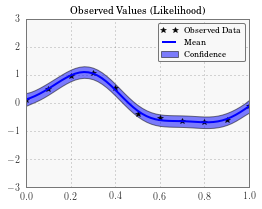

In [6]:
model.eval()
likelihood.eval()

f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
test_x = Variable(torch.linspace(0, 1, 51))
observed_pred = likelihood(model(test_x))

def ax_plot(ax, rand_var, title):
    lower, upper = rand_var.confidence_region()
    ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
    ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
    ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)

ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')